In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import albumentations as albu
import segmentation_models as sm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2

Segmentation Models: using `tf.keras` framework.


In [2]:
BACKBONE = 'efficientnetb7'

In [3]:
heigh = 320

In [38]:
class datasetcreator:
   def __init__(self,preprocess) -> None:
      self.preprocess = preprocess
      self.transforms = self.get_augmentations()

   def get_mask(self,image):
      return tf.strings.split(image,os.path.sep)[-1]

   def process_image_with_mask(self,file_path):
      image = tf.io.read_file(file_path)
      image = tf.image.decode_png(image)
      mask = self.maskspath + self.get_mask(file_path)
      mask = tf.io.read_file(mask)
      mask = tf.image.decode_png(mask)
      cond = tf.greater_equal(mask,1)
      mask = tf.where(cond,1,0)
      image = tf.cast(image,tf.uint8)
      mask = tf.cast(mask,tf.uint8)
      return image,mask
   
   def get_augmentations(self):
      transforms = albu.Compose([
            albu.Resize(heigh,heigh,always_apply=True)
        ])
      return transforms
   
   def aug_fn(self,image, mask):
      image = image[:,:,:3]
      data = {"image":image,"mask":mask}
      aug_data = self.transforms(**data)
      image = aug_data["image"]
      mask = aug_data["mask"]
      image = tf.cast(image, tf.float32)
      mask = tf.cast(mask, tf.float32)
      image = self.preprocess(image)
      return image,mask
   
   def process_data(self,image, mask):
    image,mask = tf.numpy_function(self.aug_fn,inp = (image,mask),Tout=(tf.float32,tf.float32))
    return image, mask

   def __call__(self,imagepath,maskspath):
      self.maskspath = maskspath
      dataset = tf.data.Dataset.list_files(imagepath)
      dataset = dataset.map(self.process_image_with_mask)
      dataset = dataset.map(self.process_data)
      return dataset.batch(4)

In [39]:
dataset = datasetcreator(sm.get_preprocessing(BACKBONE))

In [40]:
valdata = dataset('crosval/val/*png','castom-masks/masks_machine/')
len(valdata)

3

In [41]:
traindata = dataset('crosval/train/*png','castom-masks/masks_machine/')
len(traindata)

11

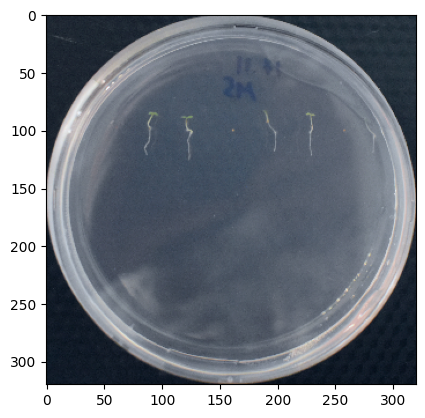

tf.Tensor([], shape=(0,), dtype=float32)


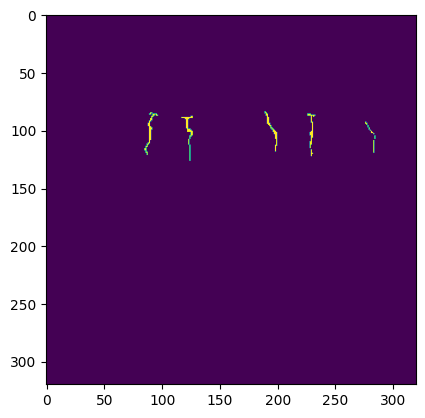

In [48]:
for image,mask in traindata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))
        print(mask[mask > 1])

In [9]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

258434480/258434480 [==============================] - 198s 1us/step


In [24]:
#tf.keras.utils.plot_model(model)

In [ ]:
def scheduler(epoch, lr):
  if epoch < 10 or epoch % 2 == 1:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback =[
    tf.keras.callbacks.EarlyStopping(min_delta=0.0001,patience=3,verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='bestmodel/',save_best_only=True,monitor='loss',verbose=1)
]

In [10]:
# fit model
model_history = model.fit(
    traindata,
    epochs=30,
    validation_data=valdata,
    callbacks=callback,
    )

Epoch 1/10
11/11 [==============================] - 121s 10s/step - loss: 1.5136 - iou_score: 0.0136 - val_loss: 2.3907 - val_iou_score: 0.0194
Epoch 2/10
11/11 [==============================] - 107s 10s/step - loss: 1.2461 - iou_score: 0.0238 - val_loss: 6.0877 - val_iou_score: 0.0225
Epoch 3/10
11/11 [==============================] - 108s 10s/step - loss: 1.1141 - iou_score: 0.0422 - val_loss: 1.7946 - val_iou_score: 0.0747
Epoch 4/10
11/11 [==============================] - 105s 10s/step - loss: 1.0293 - iou_score: 0.0696 - val_loss: 1.1323 - val_iou_score: 0.1049
Epoch 5/10
11/11 [==============================] - 109s 10s/step - loss: 0.9570 - iou_score: 0.1081 - val_loss: 1.1135 - val_iou_score: 0.1117
Epoch 6/10
11/11 [==============================] - 95s 9s/step - loss: 0.8768 - iou_score: 0.1662 - val_loss: 1.0440 - val_iou_score: 0.0951
Epoch 7/10
11/11 [==============================] - 107s 10s/step - loss: 0.7779 - iou_score: 0.2498 - val_loss: 1.1080 - val_iou_score: 0

In [11]:
testdata = dataset('crosval/test/*png','castom-masks/masks_machine/')

In [ ]:
results = model.evaluate(testdata)
results

In [51]:
for i,image in enumerate(testdata.take(len(testdata))):
    mask = model.predict((tf.reshape(image[0],[1,heigh,heigh,3])))
    mask = tf.keras.utils.array_to_img(mask[0])
    img = tf.keras.utils.array_to_img(image[0])
    img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(np.array(mask),cv2.COLOR_GRAY2RGB)
    vis = np.concatenate((img, mask), axis=1)
    cv2.imwrite('output/'+str(i)+'.png', vis)

1/1 [==============================] - 0s 382ms/step
